In [2]:
import scipy.io as io
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torch
from torch.optim import lr_scheduler
from util.misc import AverageMeter
from util.misc import to_device, mkdirs, rescale_result
from util.visualize import visualize_network_output
from util.summary import LogSummary
from datetime import datetime
import time
import subprocess
from util.visualize import visualize_detection


# datasets
from dataset.data_util import pil_load_img
from dataset.dataload import TextInstance, TextDataset
import torch.utils.data as data
from dataset.total_text import TotalText
from dataset.synth_text import SynthText
from util.config import config as cfg, update_config, print_config

# models
from models import TextNet
from util.detection import TextDetector

# Losses
from loss import TextLoss

In [3]:
# 学習の設定
dataset = "total-text"
original = False # 論文と同等のネットワークか
batch_size = 1
resnet = True

# define backbone_name for model save+load
if original:
    backbone_name = "vgg16-original"
else:
    backbone_name = "vgg16"
if resnet:
    backbone_name = "resnet50"

# Load path
WeightPath = "weights/totaltext/textsnake_{}_80.pth".format(backbone_name)

## データセット、モデルの準備

In [10]:
# Define model
if resnet:
    model = TextNet(original=original, backbone="resnet50")
else:
    model = TextNet(original=original)

# Load weights
model.load_state_dict(torch.load(WeightPath)['model'])

# Cuda?
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
if device=="cuda":
    cudnn.benchmark = True
model = model.to(device)

# Detector(要coderead)
# Thresholds Ttr, Ttcl are set to (0.4, 0.6) 
tr_thresh = 0.4
tcl_thresh = 0.6
detector = TextDetector(model, tr_thresh=tr_thresh, tcl_thresh=tcl_thresh)

In [11]:
# Normalize only
from util.augmentation import BaseTransform

# Setup dataset
testset = TotalText(
        data_root='data/total-text',
        ignore_list=None,
        is_training=False,
        transform=BaseTransform(size=cfg.input_size, mean=cfg.means, std=cfg.stds)
    )
test_loader = data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=0)

## 推論処理

In [12]:
# 推論結果の書き出し
def write_to_file(contours, file_path):
    """
    :param contours: [[x1, y1], [x2, y2]... [xn, yn]]
    :param file_path: target file path
    """
    # according to total-text evaluation method, output file shoud be formatted to: y0,x0, ..... yn,xn
    with open(file_path, 'w') as f:
        for cont in contours:
            cont = np.stack([cont[:, 1], cont[:, 0]], 1)
            cont = cont.flatten().astype(str).tolist()
            cont = ','.join(cont)
            f.write(cont + '\n')

まずは画像一枚でdetectionの実験

In [48]:
# Load a single image
image, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map, meta = testset[0]
# Infer a image
with torch.no_grad():
    # get detection result
    contours, output = detector.detect(torch.from_numpy(image).unsqueeze(0))

show tr


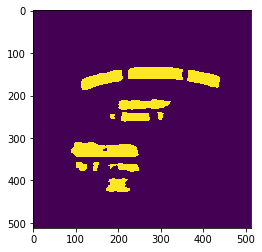

show tcl


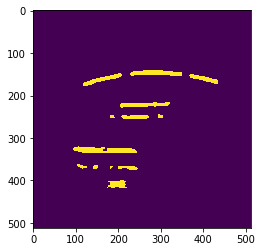

In [53]:
# Plot tr_pred
# しきい値でthresholdingする。
tr_pred = output["tr"][1] > 0.8

# tcl はtrでマスクし、しきい値(0.4)でthresholdingする。
tcl_pred = output["tcl"][1]*tr_pred > 0.4

cos_pred = output["cos"]
sin_pred = output["sin"]
radii_pred = output["radii"]

print("show tr")
plt.imshow(tr_pred)
plt.show()

print("show tcl")
plt.imshow(tcl_pred)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


show tr area overlayed


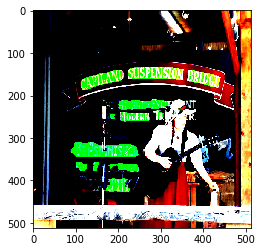

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


show tcl area overlayed


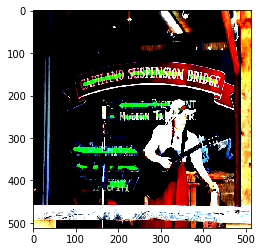

In [54]:
print("show tr area overlayed")
plt.imshow(image.transpose([1,2,0]) + np.array([np.zeros_like(tr_pred),tr_pred,np.zeros_like(tr_pred)]).transpose([1,2,0])*5)
plt.show()
print("show tcl area overlayed")
plt.imshow(image.transpose([1,2,0]) + np.array([np.zeros_like(tcl_pred),tcl_pred,np.zeros_like(tcl_pred)]).transpose([1,2,0])*5)
plt.show()

ポストプロセスについて。

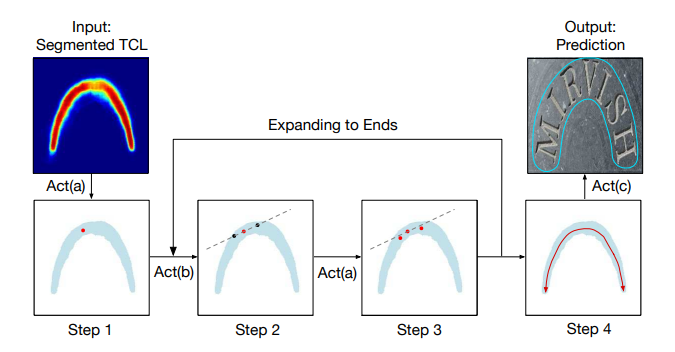


In [56]:
from util.misc import fill_hole, regularize_sin_cos

## ポストプロセスの処理フロー

# 1. regularize sin and cos
sin_pred, cos_pred = regularize_sin_cos(sin_pred, cos_pred)

# 2. TCL結果をsin, cos推論結果を用いて整理
detect_result = detector.build_tcl(tcl_pred, sin_pred, cos_pred, radii_pred)
# ここが最も重要なステップ.
# Step1-3を繰り返し、最終的にStep 4のようなrefined TCL結果を得る
# detect_result = (n,3): 各中心点における(x,y,radii)

# 3. TR結果と上記のTCLより文字領域の最終結果を得る
output = detector.postprocessing(image, detect_result, tr_pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


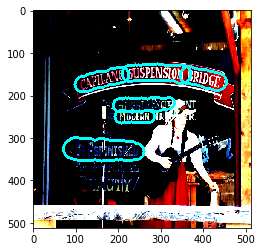

In [64]:
# 推論結果を可視化
image2 = image.transpose([1,2,0])
for polygon in output:
    poly = np.asarray(polygon).astype(np.int32)
    poly = poly.reshape((-1,1,2))
    image2 = cv2.polylines(image2, [poly], True, (0,255,255), 5)
plt.imshow(image2)
plt.show()

上記処理をinference scriptにwrap

In [6]:
def inference(detector, test_loader, output_dir):
    total_time = 0.
    for i, (image, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map, meta) in enumerate(test_loader):

        image, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map = to_device(
            image, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map)

        torch.cuda.synchronize()
        start = time.time()

        idx = 0 # test mode can only run with batch_size == 1

        # get detection result
        contours, output = detector.detect(image)

        torch.cuda.synchronize()
        end = time.time()
        total_time += end - start
        fps = (i + 1) / total_time
        print('detect {} / {} images: {}. ({:.2f} fps)'.format(i + 1, len(test_loader), meta['image_id'][idx], fps))

        # visualization
        tr_pred, tcl_pred = output['tr'], output['tcl']
        img_show = image[idx].permute(1, 2, 0).cpu().numpy()
        img_show = ((img_show * cfg.stds + cfg.means) * 255).astype(np.uint8)

        pred_vis = visualize_detection(img_show, contours, tr_pred[1], tcl_pred[1])
        gt_contour = []
        for annot, n_annot in zip(meta['annotation'][idx], meta['n_annotation'][idx]):
            if n_annot.item() > 0:
                gt_contour.append(annot[:n_annot].int().cpu().numpy())
        gt_vis = visualize_detection(img_show, gt_contour, tr_mask[idx].cpu().numpy(), tcl_mask[idx].cpu().numpy())
        im_vis = np.concatenate([pred_vis, gt_vis], axis=0)
        path = os.path.join(cfg.vis_dir, '{}_test'.format(cfg.exp_name), meta['image_id'][idx])
        cv2.imwrite(path, im_vis)

        H, W = meta['Height'][idx].item(), meta['Width'][idx].item()
        img_show, contours = rescale_result(img_show, contours, H, W)

        # write to file
        mkdirs(output_dir)
        write_to_file(contours, os.path.join(output_dir, meta['image_id'][idx].replace('jpg', 'txt')))

推論を実行。

In [7]:
output_dir = os.path.join(cfg.output_dir, cfg.exp_name)
inference(detector, test_loader, output_dir)

detect 1 / 300 images: img579.jpg. (9.45 fps)
detect 2 / 300 images: img1553.jpg. (7.33 fps)
detect 3 / 300 images: img633.jpg. (8.57 fps)
detect 4 / 300 images: img1099.jpg. (9.22 fps)
detect 5 / 300 images: img546.jpg. (9.94 fps)
detect 6 / 300 images: img91.jpg. (10.49 fps)
detect 7 / 300 images: img660.jpg. (11.10 fps)
detect 8 / 300 images: img600.jpg. (10.77 fps)
detect 9 / 300 images: img1192.jpg. (11.20 fps)
detect 10 / 300 images: img657.jpg. (11.41 fps)
detect 11 / 300 images: img1548.jpg. (11.40 fps)
detect 12 / 300 images: img549.jpg. (10.90 fps)
detect 13 / 300 images: img644.jpg. (11.09 fps)
detect 14 / 300 images: img1393.jpg. (10.94 fps)
detect 15 / 300 images: img561.jpg. (10.97 fps)
detect 16 / 300 images: img612.jpg. (11.07 fps)
detect 17 / 300 images: img609.jpg. (10.68 fps)
detect 18 / 300 images: img199.jpg. (10.55 fps)
detect 19 / 300 images: img613.jpg. (10.64 fps)
detect 20 / 300 images: img610.jpg. (10.93 fps)
detect 21 / 300 images: img1191.jpg. (11.05 fps)
d

detect 171 / 300 images: img544.jpg. (11.07 fps)
detect 172 / 300 images: img792.jpg. (11.08 fps)
detect 173 / 300 images: img3.jpg. (11.09 fps)
detect 174 / 300 images: img539.jpg. (11.12 fps)
detect 175 / 300 images: img1198.jpg. (11.14 fps)
detect 176 / 300 images: img97.jpg. (11.14 fps)
detect 177 / 300 images: img7.jpg. (11.15 fps)
detect 178 / 300 images: img677.jpg. (11.16 fps)
detect 179 / 300 images: img640.jpg. (11.16 fps)
detect 180 / 300 images: img621.jpg. (11.17 fps)
detect 181 / 300 images: img994.jpg. (11.17 fps)
detect 182 / 300 images: img654.jpg. (11.12 fps)
detect 183 / 300 images: img622.jpg. (11.08 fps)
detect 184 / 300 images: img559.jpg. (11.01 fps)
detect 185 / 300 images: img620.jpg. (11.02 fps)
detect 186 / 300 images: img498.jpg. (11.04 fps)
detect 187 / 300 images: img195.jpg. (11.04 fps)
detect 188 / 300 images: img648.jpg. (11.04 fps)
detect 189 / 300 images: img581.jpg. (11.04 fps)
detect 190 / 300 images: img567.jpg. (11.05 fps)
detect 191 / 300 images:

## 公式スクリプトを使いスコア算出

In [8]:
print('Computing DetEval in {}/{}'.format(cfg.output_dir, cfg.exp_name))
#subprocess.call(['python', 'dataset/total_text/Evaluation_Protocol/Python_scripts/Deteval.py', cfg.exp_name, '--tr', '0.7', '--tp', '0.6'])
subprocess.call(['python', 'dataset/total_text/Evaluation_Protocol/Python_scripts/Deteval.py', cfg.exp_name, '--tr', '0.8', '--tp', '0.4'])

Computing DetEval in output/totaltext


0